### 環境設定

In [ ]:
# h5py版本要是2.XX，否則會出現問題
!pip uninstall h5py
!pip install h5py==2.10.0

Found existing installation: h5py 2.10.0
Uninstalling h5py-2.10.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/h5py-2.10.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/h5py/*
Proceed (y/n)? y
  Successfully uninstalled h5py-2.10.0
  Using cached h5py-2.10.0-cp37-cp37m-manylinux1_x86_64.whl (2.9 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras 2.2.4 requires keras-applications>=1.0.6, which is not installed.
tensorflow 2.6.0 requires h5py~=3.1.0, but you have h5py 2.10.0 which is incompatible.
tensorflow 2.6.0 requires keras~=2.6, but you have keras 2.2.4 which is incompatible.


In [ ]:
%tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
1.15.2


In [ ]:
!pip install keras==2.2.4 # 需要安裝 keras 2.2.4 的版本
import keras
print(keras.__version__)

2.2.4


Using TensorFlow backend.


### 使用 Google Colab 並下載keras-yolo3的Github倉儲

In [ ]:
import os
from google.colab import drive 
drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# 下載基於 keras 的 yolov3 程式碼
%cd 'gdrive/My Drive'
if not os.path.exists("./keras-yolo3"):
  !git clone https://github.com/qqwweee/keras-yolo3 # 如果之前已經下載過就可以註解掉
%cd keras-yolo3


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive
/content/gdrive/My Drive/keras-yolo3


### 下載 yolov3 的網路權重並轉為keras可讀取的格式

In [ ]:
if not os.path.exists("model_data/yolo.h5"):
  # 下載 yolov3 的網路權重，並且把權重轉換為 keras 能夠讀取的格式
  print("Model doesn't exist, downloading...")
  os.system("wget https://pjreddie.com/media/files/yolov3.weights")
  print("Converting yolov3.weights to yolo.h5...")
  os.system("python convert.py yolov3.cfg yolov3.weights model_data/yolo.h5")
else:
  print("Model exist")

Model exist


### 下載袋鼠和浣熊的資料集

In [ ]:
if not os.path.exists("dataset"):
  os.mkdir("dataset")
  os.chdir("./dataset")
  print("downloading raccoon dataset.")
  !git clone https://github.com/experiencor/raccoon_dataset.git raccoon
  !git clone https://github.com/experiencor/kangaroo.git kangaroo
  os.chdir("..")
else:
  print("dataset exists")


dataset exists


### 轉換訓練時需要的資料型態

In [ ]:
import xml.etree.ElementTree as ET # 載入能夠 Parser xml 文件的 library
from os import getcwd


# 把 annotation 轉換訓練時需要的資料形態
def convert_annotation(data_classes, image_id, list_file):
    in_file = open("./dataset/%s/annotations/%s.xml"%(data_classes, image_id))
    tree=ET.parse(in_file)
    root = tree.getroot()

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classes or int(difficult)==1:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
        list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))


'\nlist_file = open("tttrain.txt", "w")\nconvert_annotation("raccoon", "raccoon-1", list_file)\nprint(os.getcwd())\n'

### 整理要訓練的資料集
各取50張，共100張

In [ ]:
dataset_file = open("train_annotation.txt", "w")
classes = ["raccoon", "kangaroo"]
base_dir = "/content/gdrive/My Drive/keras-yolo3"


if os.getcwd() != base_dir:
  os.chdir(base_dir)

for data_classes in classes:
  if data_classes == "raccoon":
    file_names = os.listdir("./dataset/raccoon/annotations/")
    file_names = [i.rstrip(".xml") for i in file_names]
    for file_name in file_names[0: 50]:
      # 注意當前路徑是在 /content/gdrive/My Drive/keras-yolo3 所以要從這目錄去設定路徑
      dataset_file.write("./dataset/raccoon/images/%s.jpg"%(file_name))
      convert_annotation(data_classes, file_name, dataset_file)
      dataset_file.write("\n")
      

  if data_classes == "kangaroo":
    file_names = os.listdir("./dataset/kangaroo/annotations/")
    file_names = [i.rstrip(".xml") for i in file_names]
    for file_name in file_names[0: 50]:
      dataset_file.write("./dataset/kangaroo/images/%s.jpg"%(file_name))
      convert_annotation(data_classes, file_name, dataset_file)
      dataset_file.write("\n")
  

### 建立驗證集
各取20張，共40張

In [ ]:
dataset_file = open("valid_annotation.txt", "w")
classes = ["raccoon", "kangaroo"]
base_dir = "/content/gdrive/My Drive/keras-yolo3"


if os.getcwd() != base_dir:
  os.chdir(base_dir)

for data_classes in classes:
  if data_classes == "raccoon":
    file_names = os.listdir("./dataset/raccoon/annotations/")
    file_names = [i.rstrip(".xml") for i in file_names]
    for file_name in file_names[-20: ]:
      dataset_file.write("./dataset/raccoon/images/%s.jpg"%(file_name))
      convert_annotation(data_classes, file_name, dataset_file)
      dataset_file.write("\n")
      

  if data_classes == "kangaroo":
    file_names = os.listdir("./dataset/kangaroo/annotations/")
    file_names = [i.rstrip(".xml") for i in file_names]
    for file_name in file_names[-20: ]:
      dataset_file.write("./dataset/kangaroo/images/%s.jpg"%(file_name))
      convert_annotation(data_classes, file_name, dataset_file)
      dataset_file.write("\n")
  

### 載入train.py所需要的套件

In [ ]:
# 將 train.py 所需要的套件載入
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

### 轉換 yolov3 的網路權重

In [ ]:
if not os.path.exists("model_data/yolo_weights.h5"):
  print("Converting pretrained YOLOv3 weights for training")
  os.system("python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5") 
else:
  print("Pretrained weights exists")

Pretrained weights exists


In [ ]:
annotation_path = 'train_annotation.txt' # 轉換好格式的標註檔案
log_dir = 'logs/001/' # 訓練好的模型儲存的路徑
# classes_path = 'model_data/voc_classes.txt'
classes_path = 'model_data/final_project_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416) # multiple of 32, hw

is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/tiny_yolo_weights.h5')
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/yolo_weights.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 16
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=50,
            initial_epoch=0,
            callbacks=[logging, checkpoint])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')

# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.
if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 8 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=100,
        initial_epoch=50,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'trained_weights_final.h5')

Create YOLOv3 model with 9 anchors and 2 classes.


/usr/local/lib/python3.7/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 21) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.7/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.7/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 21) vs (255, 512, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.7/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.7/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_75 due to mismatch in shape ((1,

Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 90 samples, val on 10 samples, with batch size 16.




Epoch 1/50
5/5 [==============================] - 17s 3s/step - loss: 11191.8451 - val_loss: 9112.9561

Epoch 2/50
5/5 [==============================] - 8s 2s/step - loss: 6705.9699 - val_loss: 5212.3911
Epoch 3/50
5/5 [==============================] - 9s 2s/step - loss: 3932.1313 - val_loss: 3034.2378
Epoch 4/50
5/5 [==============================] - 4s 898ms/step - loss: 2363.7147 - val_loss: 1784.6493
Epoch 5/50
5/5 [==============================] - 5s 926ms/step - loss: 1473.6202 - val_loss: 1234.6309
Epoch 6/50
5/5 [==============================] - 5s 909ms/step - loss: 975.8708 - val_loss: 837.4197
Epoch 7/50
5/5 [==============================] - 5s 1s/step - loss: 729.4773 - val_loss: 628.8773
Epoch 8/50
5/5 [===================

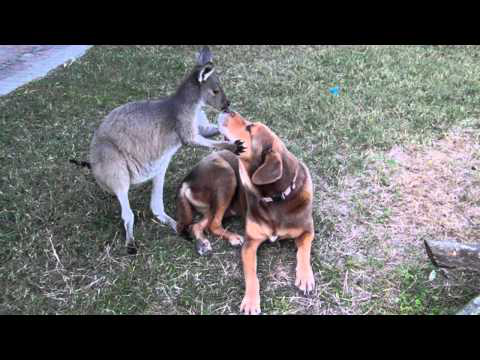

In [ ]:
from PIL import Image
# image = Image.open('dog.jpg')
image = Image.open("./dataset/kangaroo/images/00023.jpg")
image

In [ ]:
from yolo import YOLO
# yolo_model = YOLO(model_path='logs/000/trained_weights_final.h5', classes_path="model_data/final_project_classes.txt")
yolo_model = YOLO(model_path='logs/001/trained_weights_final.h5', classes_path="model_data/final_project_classes.txt")
r_image = yolo_model.detect_image(image)

logs/001/trained_weights_final.h5 model, anchors, and classes loaded.
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (91, 26) (238, 275)
3.6006767569997464


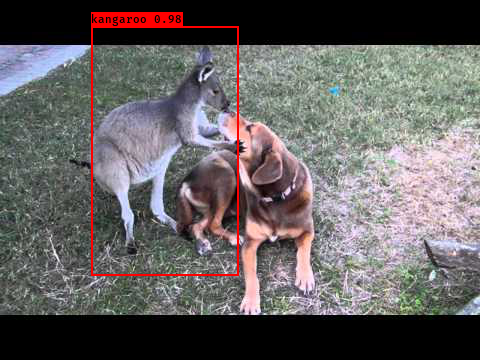

In [ ]:
r_image